In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-kaglle/kaggle.json
/kaggle/input/ml-competition-2024-for-ukrainians/sample_submission.csv
/kaggle/input/ml-competition-2024-for-ukrainians/train.csv
/kaggle/input/ml-competition-2024-for-ukrainians/test.csv
/kaggle/input/big-sales-prediction-dataset/Big Sales Data.csv


In [2]:
USE_VAE = False
USE_ORIGINAL_DATA = True

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import lightgbm as lgb
# Load data
train_data = pd.read_csv('/kaggle/input/ml-competition-2024-for-ukrainians/train.csv')
test_data = pd.read_csv('/kaggle/input/ml-competition-2024-for-ukrainians/test.csv')
# Retain 'id' column for later use if it exists
test_ids = test_data['id'] if 'id' in test_data.columns else test_data.index
additional_data = pd.read_csv('/kaggle/input/big-sales-prediction-dataset/Big Sales Data.csv')
if USE_ORIGINAL_DATA:
    train_data = pd.concat([train_data, additional_data], axis=0)
sample_submission = pd.read_csv('/kaggle/input/ml-competition-2024-for-ukrainians/sample_submission.csv')


In [4]:
# Function to reduce memory usage
def reduce_memory_usage(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    return df

# EDA

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

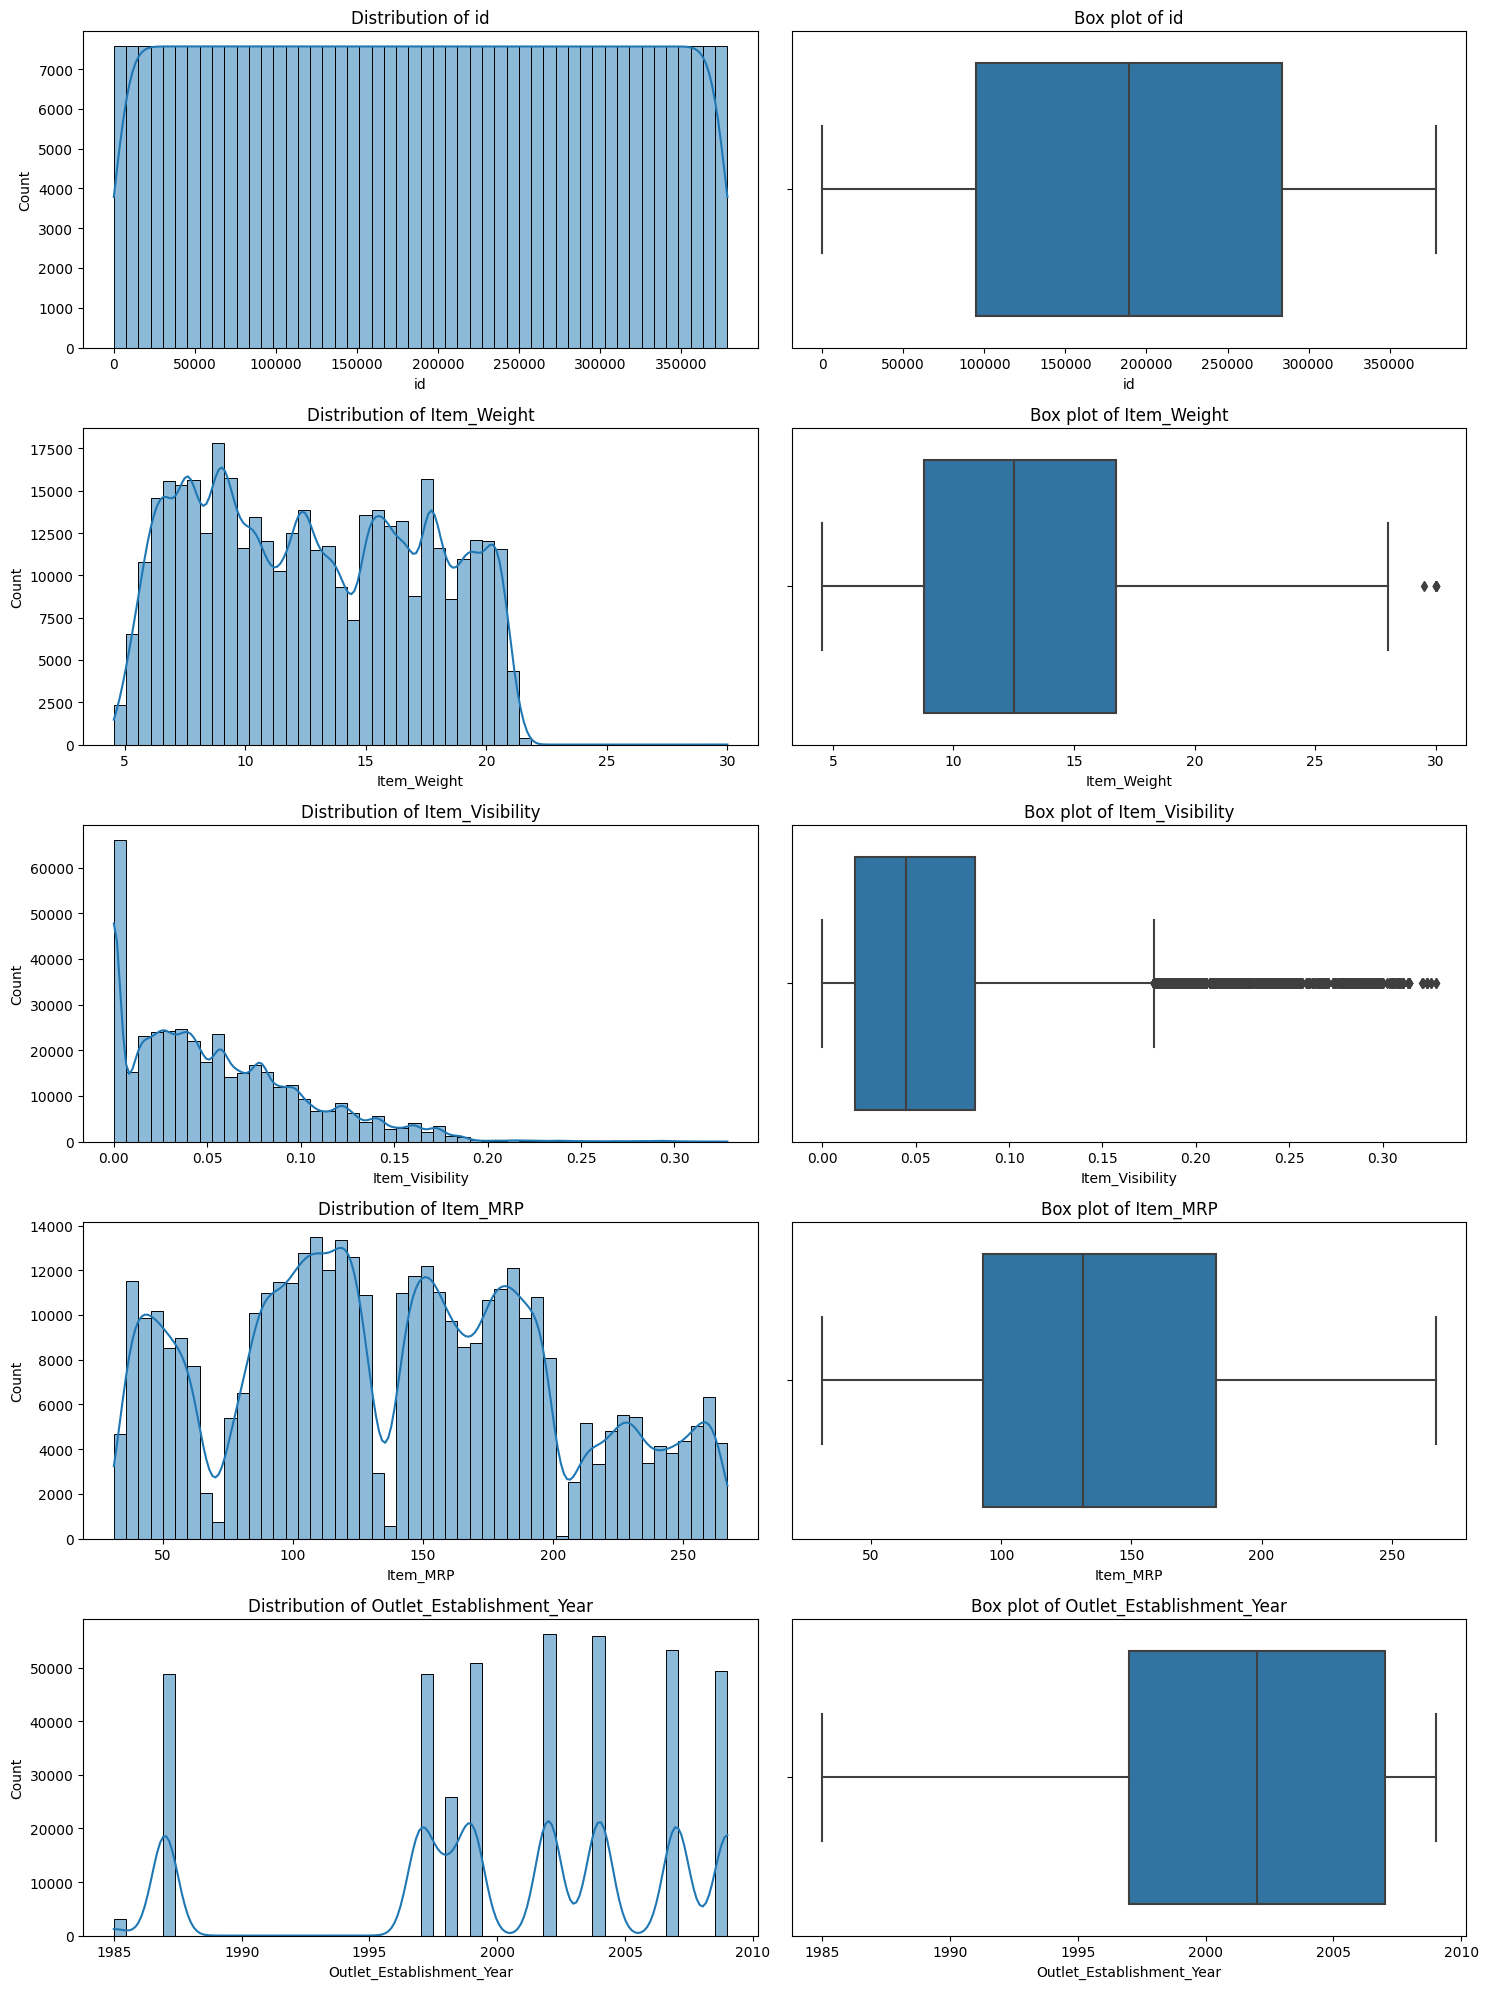

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric features
numeric_features = train_data.select_dtypes(include=[np.number]).columns.tolist()

# Remove the target variable from the list
numeric_features.remove('Item_Outlet_Sales')

# Plot histograms and box plots for each numeric feature
plt.figure(figsize=(15, 20))
for i, feature in enumerate(numeric_features):
    plt.subplot(len(numeric_features), 2, 2*i+1)
    sns.histplot(train_data[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    
    plt.subplot(len(numeric_features), 2, 2*i+2)
    sns.boxplot(x=train_data[feature])
    plt.title(f'Box plot of {feature}')

plt.tight_layout()
plt.show()


In [6]:
# Calculate skewness for each numeric feature
skewness = train_data[numeric_features].skew().sort_values(ascending=False)
print("Skewness of numeric features:")
print(skewness)

Skewness of numeric features:
Item_Visibility              1.009443e+00
Item_MRP                     1.847546e-01
Item_Weight                  1.083004e-01
id                           3.819076e-16
Outlet_Establishment_Year   -7.960192e-01
dtype: float64


In [7]:
# Calculate skewness for numerical columns
numerical_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
train_skewness = train_data[numerical_columns].skew()
test_skewness = test_data[numerical_columns].skew()

# Define a threshold for skewness; typically values > 0.5 or < -0.5 are considered skewed
skewed_columns_train = train_skewness[abs(train_skewness) > 0.5].index
skewed_columns_test = test_skewness[abs(test_skewness) > 0.5].index

# Apply transformations to reduce skewness in training data
for col in skewed_columns_train:
    if any(train_data[col] <= 0):  # Check if the column contains non-positive values
        # Apply a log transformation to columns with only positive values
        train_data[col] = np.log1p(train_data[col])
    else:
        # Apply Box-Cox transformation to handle non-positive values
        train_data[col], _ = boxcox(train_data[col] + 1)  # Add 1 to avoid zero values

# Apply transformations to reduce skewness in test data
for col in skewed_columns_test:
    if any(test_data[col] <= 0):  # Check if the column contains non-positive values
        # Apply a log transformation to columns with only positive values
        test_data[col] = np.log1p(test_data[col])
    else:
        # Apply Box-Cox transformation to handle non-positive values
        test_data[col], _ = boxcox(test_data[col] + 1)  # Add 1 to avoid zero values

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


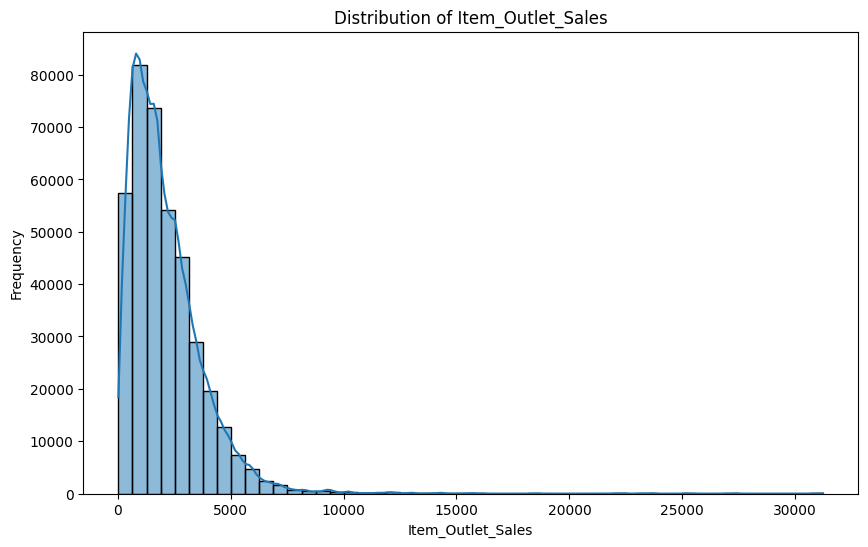

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Item_Outlet_Sales'], bins=50, kde=True)
plt.title('Distribution of Item_Outlet_Sales')
plt.xlabel('Item_Outlet_Sales')
plt.ylabel('Frequency')
plt.show()

# Feature Engineering

In [9]:
# Feature Engineering
train_data['Item_Visibility_MRP_Ratio'] = train_data['Item_Visibility'] / train_data['Item_MRP']
test_data['Item_Visibility_MRP_Ratio'] = test_data['Item_Visibility'] / test_data['Item_MRP']
train_data['Item_Weight_Visibility_Ratio'] = train_data['Item_Weight'] / train_data['Item_Visibility']
test_data['Item_Weight_Visibility_Ratio'] = test_data['Item_Weight'] / test_data['Item_Visibility']
train_data['Item_Visibility_Squared'] = train_data['Item_Visibility'] ** 2
test_data['Item_Visibility_Squared'] = test_data['Item_Visibility'] ** 2

#Create a new feature for Outlet Age
train_data['Outlet_Age'] = 2024 - train_data['Outlet_Establishment_Year']
test_data['Outlet_Age'] = 2024 - test_data['Outlet_Establishment_Year']

# Clean the Item_Fat_Content column
train_data['Item_Fat_Content'] = train_data['Item_Fat_Content'].replace(['LF', 'low fat'], 'Low Fat').replace('reg', 'Regular')
test_data['Item_Fat_Content'] = test_data['Item_Fat_Content'].replace(['LF', 'low fat'], 'Low Fat').replace('reg', 'Regular')

# Combine similar Item_Type categories
train_data['Item_Type_Combined'] = train_data['Item_Type'].apply(lambda x: 'Non-Consumable' if x in ['Household', 'Health and Hygiene', 'Others'] else 'Consumable')
test_data['Item_Type_Combined'] = test_data['Item_Type'].apply(lambda x: 'Non-Consumable' if x in ['Household', 'Health and Hygiene', 'Others'] else 'Consumable')

# Data preparation

In [10]:
# Encoding categorical variables
categorical_columns = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Type_Combined']
train_data = pd.get_dummies(train_data, columns=categorical_columns)
test_data = pd.get_dummies(test_data, columns=categorical_columns)

# Aligning test data columns with train data columns
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

In [11]:
# Replace zero visibility values with the mean visibility
mean_visibility = train_data['Item_Visibility'].mean()
train_data['Item_Visibility'] = train_data['Item_Visibility'].replace(0, mean_visibility)
test_data['Item_Visibility'] = test_data['Item_Visibility'].replace(0, mean_visibility)

In [12]:
# Remove outliers in Item_Outlet_Sales using IQR method
Q1_sales = train_data['Item_Outlet_Sales'].quantile(0.25)
Q3_sales = train_data['Item_Outlet_Sales'].quantile(0.75)
IQR_sales = Q3_sales - Q1_sales
train_data = train_data[~((train_data['Item_Outlet_Sales'] < (Q1_sales - 1.5 * IQR_sales)) | 
                              (train_data['Item_Outlet_Sales'] > (Q3_sales + 1.5 * IQR_sales)))]

# Remove outliers in Item_Weight using IQR method
Q1_weight = train_data['Item_Weight'].quantile(0.25)
Q3_weight = train_data['Item_Weight'].quantile(0.75)
IQR_weight = Q3_weight - Q1_weight
train_data = train_data[~((train_data['Item_Weight'] < (Q1_weight - 1.5 * IQR_weight)) | 
                              (train_data['Item_Weight'] > (Q3_weight + 1.5 * IQR_weight)))]


In [13]:
# Reduce memory usage
train_data = reduce_memory_usage(train_data)
test_data = reduce_memory_usage(test_data)

In [14]:
# Checking for missing values in train and test data
print(train_data.isnull().sum())
print(test_data.isnull().sum())
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
# Handle missing values
train_data['Item_Weight'].fillna(train_data['Item_Weight'].mean(), inplace=True)
test_data['Item_Weight'].fillna(test_data['Item_Weight'].mean(), inplace=True)
# Fill NaNs by column means only if they have NaNs
for col in train_data.columns:
    if train_data[col].isna().any():
        train_data[col].fillna(train_data[col].mean(), inplace=True)
for col in test_data.columns:
    if test_data[col].isna().any():
        test_data[col].fillna(test_data[col].mean(), inplace=True)

id                                   13680
Item_Identifier                          0
Item_Weight                           2072
Item_Visibility                          0
Item_Type                                0
Item_MRP                                 0
Outlet_Identifier                        0
Outlet_Establishment_Year                0
Item_Outlet_Sales                        0
Item_Visibility_MRP_Ratio                0
Item_Weight_Visibility_Ratio          2072
Item_Visibility_Squared                  0
Outlet_Age                               0
Item_Fat_Content_Low Fat                 0
Item_Fat_Content_Regular                 0
Outlet_Size_High                         0
Outlet_Size_Medium                       0
Outlet_Size_Small                        0
Outlet_Location_Type_Tier 1              0
Outlet_Location_Type_Tier 2              0
Outlet_Location_Type_Tier 3              0
Outlet_Type_Grocery Store                0
Outlet_Type_Supermarket Type1            0
Outlet_Type

/tmp/ipykernel_34/2705562751.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Item_Weight'].fillna(train_data['Item_Weight'].mean(), inplace=True)
/tmp/ipykernel_34/2705562751.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [15]:
# Create interaction features
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
train_interactions = interaction.fit_transform(train_data[numerical_columns])
test_interactions = interaction.transform(test_data[numerical_columns])

interaction_feature_names = interaction.get_feature_names_out(numerical_columns)
train_interaction_df = pd.DataFrame(train_interactions, columns=interaction_feature_names).drop(columns=numerical_columns)
test_interaction_df = pd.DataFrame(test_interactions, columns=interaction_feature_names).drop(columns=numerical_columns)

train_data = train_data.reset_index(drop=True).join(train_interaction_df)
test_data = test_data.reset_index(drop=True).join(test_interaction_df)

In [16]:
# Dropping the target variable from test data
test_data.drop(['Item_Outlet_Sales'], axis=1, inplace=True)
# Apply log transformation to the target variable
train_data['Log_Item_Outlet_Sales'] = np.log1p(train_data['Item_Outlet_Sales'])
# Drop 'Item_Identifier' and 'Item_Type'
train_data.drop(columns=['Item_Identifier', 'Item_Type', 'Outlet_Identifier'], inplace=True)
test_data.drop(columns=['Item_Identifier', 'Item_Type', 'Outlet_Identifier'], inplace=True)

In [17]:
# Use the transformed target variable for training
y_train_rf = train_data['Log_Item_Outlet_Sales']
X_train_rf = train_data.drop(['Item_Outlet_Sales', 'Log_Item_Outlet_Sales'], axis=1)

In [18]:
from sklearn.feature_selection import SelectFromModel
# Feature selection using RandomForestRegressor
feature_selector = SelectFromModel(RandomForestRegressor(n_estimators=100, verbose=2), threshold='mean')
feature_selector.fit(X_train_rf, y_train_rf)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  4.6min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

SelectFromModel(estimator=RandomForestRegressor(verbose=2), threshold='mean')

In [19]:
selected_features = X_train_rf.columns[feature_selector.get_support()]
train_data = train_data[selected_features.to_list() + ['Log_Item_Outlet_Sales']]
test_data = test_data[selected_features.to_list()]

In [20]:
# Use the transformed target variable for training
y = train_data['Log_Item_Outlet_Sales']
X = train_data.drop(['Log_Item_Outlet_Sales'], axis=1)

In [21]:
# Scaling features
scaler = StandardScaler()
X = scaler.fit_transform(X)
test_data = scaler.transform(test_data)

In [22]:
# Splitting the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
selected_features

Index(['id', 'Item_MRP', 'Item_Visibility_MRP_Ratio',
       'Item_Weight_Visibility_Ratio', 'Item_Weight Item_Visibility',
       'Item_Weight Item_MRP', 'Item_Visibility Item_MRP'],
      dtype='object')

# VAE definition

In [24]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
# Define Sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define Encoder layer
class Encoder(layers.Layer):
    """Maps inputs to a triplet (z_mean, z_log_var, z)."""
    def __init__(self, latent_dim=32, intermediate_dim=64, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

# Define Decoder layer
class Decoder(layers.Layer):
    """Converts z, the encoded vector, back into a readable format."""
    def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)

# Define Variational AutoEncoder model
class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self, original_dim, intermediate_dim=64, latent_dim=32, name="autoencoder", **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

2024-06-27 19:50:55.685707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 19:50:55.685803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 19:50:55.818406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# VAE training

In [25]:
if USE_VAE:
    # Initialize and compile VAE
    vae = VariationalAutoEncoder(X_train.shape[1], intermediate_dim=64, latent_dim=32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    vae.compile(optimizer=optimizer)

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

    # Train the VAE
    history = vae.fit(X_train, X_train, 
                      validation_data=(X_valid, X_valid), 
                      epochs=10, 
                      batch_size=64, 
                      validation_freq=2,
                      callbacks=[early_stopping])

# Additional samples, adding to the data

In [26]:
len(X_train)

305221

In [27]:
if USE_VAE:
    # Generate synthetic data
    # Number of synthetic samples to generate
    num_synthetic_samples = 500000  # You can adjust this value as needed

    # Generate latent space samples
    latent_dim = 32  # Must match the latent_dim used in the VAE
    latent_samples = np.random.normal(size=(num_synthetic_samples, latent_dim))

    # Generate synthetic X data using the decoder
    X_synthetic = vae.decoder(latent_samples).numpy()

    # Bootstrap Y values
    y_bootstrap = np.random.choice(y_train, size=num_synthetic_samples, replace=True)

    # Combine original and synthetic data
    X_combined = np.vstack([X_train, X_synthetic])
    y_combined = np.hstack([y_train, y_bootstrap])

    # Split the combined data into training and validation sets
    X_train_augmented, X_valid_augmented, y_train_augmented, y_valid_augmented = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
else:
    X_train_augmented = X_train
    X_valid_augmented = X_valid
    y_train_augmented = y_train
    y_valid_augmented = y_valid

In [28]:
len(X_train_augmented)

305221

# Parametrs tuning

In [29]:
!pip install cupy

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [30]:
import optuna
from sklearn.model_selection import KFold
import xgboost as xgb
import cupy
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Custom scoring function for RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
# Define batch size for training
batch_size = 10000
# Convert data to NumPy arrays if they are Pandas DataFrames
if isinstance(X_train_augmented, pd.DataFrame):
    X_train_augmented = X_train_augmented.to_numpy()
if isinstance(y_train_augmented, pd.Series):
    y_train_augmented = y_train_augmented.to_numpy()
if isinstance(X_valid_augmented, pd.DataFrame):
    X_valid_augmented = X_valid_augmented.to_numpy()
if isinstance(y_valid_augmented, pd.Series):
    y_valid_augmented = y_valid_augmented.to_numpy()

# Convert data to NumPy arrays if they are Pandas DataFrames and ensure float32 for features
def convert_to_float32(df):
    if isinstance(df, pd.DataFrame):
        return df.to_numpy(dtype=np.float32)
    return df.astype(np.float32)

X_train_augmented = convert_to_float32(X_train_augmented)
y_train_augmented = y_train_augmented.to_numpy() if isinstance(y_train_augmented, pd.Series) else y_train_augmented

X_valid_augmented = convert_to_float32(X_valid_augmented)
y_valid_augmented = y_valid_augmented.to_numpy() if isinstance(y_valid_augmented, pd.Series) else y_valid_augmented
early_stopping_rounds = 10
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0),
        'early_stopping_rounds': 10,
        'tree_method': 'hist',
        'device': 'gpu'
    }
    model = xgb.XGBRegressor(**params)
    model.fit(cupy.array(X_train_augmented), cupy.array(y_train_augmented), eval_set=[(cupy.array(X_valid_augmented), cupy.array(y_valid_augmented))], verbose=False)
    y_pred = model.predict(X_valid_augmented)
    return rmsle(y_valid_augmented, y_pred)

# Run Optuna optimization for XGBoost
#study_xgb = optuna.create_study(direction='minimize')
#study_xgb.optimize(objective_xgb, n_trials=200, timeout=4800)
#best_params_xgb = study_xgb.best_params
best_params_xgb = {'max_depth': 10, 'learning_rate': 0.04883592937141047, 'n_estimators': 653, 'subsample': 0.9505872346618305, 'colsample_bytree': 0.7139269774101586, 'reg_alpha': 0.8672310048769226, 'reg_lambda': 0.7947562191329092, 'min_child_weight': 2, 'gamma': 1.427088470691496, 'scale_pos_weight': 5.3729309341382345}

In [31]:
# Define parameter search space for LightGBM
def objective_lgb(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0),
        'early_stopping_rounds': 10
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_augmented, y_train_augmented, eval_set=[(X_valid_augmented, y_valid_augmented)])
    y_pred = model.predict(X_valid_augmented)
    return rmsle(y_valid_augmented, y_pred)

# Run Optuna optimization for LightGBM
#study_lgb = optuna.create_study(direction='minimize')
#study_lgb.optimize(objective_lgb, n_trials=100, timeout=1200)
#best_params_lgb = study_lgb.best_params
best_params_lgb = {'num_leaves': 47, 'learning_rate': 0.055122967130032036, 'n_estimators': 940, 'subsample': 0.8805920698166568, 'colsample_bytree': 0.7743142120380193, 'reg_alpha': 0.8496854301667122, 'reg_lambda': 0.92223409303975}

In [33]:
# Objective function for Random Forest
def rmsle(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

# Or use a wrapper around the existing MSLE loss
def rmsle_from_msle(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return tf.sqrt(msle(y_true, y_pred))
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train_augmented, y_train_augmented)
    y_pred = model.predict(X_valid_augmented)
    return rmsle_from_msle(y_valid_augmented, y_pred)

# Run Optuna optimization for Random Forest
#study_rf = optuna.create_study(direction='minimize')
#study_rf.optimize(objective_rf, n_trials=100, timeout=2400)
#best_params_rf = study_rf.best_params
best_params_rf = {'n_estimators': 562, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 0.4250061922775368, 'bootstrap': False}

# Model training

In [35]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
# Define the base models
base_models = [
    ('xgb', xgb.XGBRegressor(tree_method='hist',device='gpu', **best_params_xgb)),
    ('lgb', lgb.LGBMRegressor(**best_params_lgb)),
    ('rf', RandomForestRegressor(**best_params_rf,random_state=42))
]

# Define the stacking model
stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=xgb.XGBRegressor(tree_method='hist',device='gpu')
)

# Train the stacking model
stack_model.fit(X_train_augmented, y_train_augmented)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 305221, number of used features: 7
[LightGBM] [Info] Start training from score 7.313965


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:59:17] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 244176, number of used features: 7
[LightGBM] [Info] Start training from score 7.314000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 244177, number of used features: 7
[LightGBM] [Info] Start training from score 7.313198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 244177, number of used features: 7
[LightGBM] [Info] Start tra

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7139269774101586,
                                            device='gpu',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=1.427088470691496,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_...
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...))

# Prediction

In [36]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, make_scorer

# Function to calculate RMSLE with clipping to prevent overflow
def rmsle(y_true, y_pred):
    y_true = np.clip(y_true, 0, np.log1p(np.finfo(np.float64).max))
    y_pred = np.clip(y_pred, 0, np.log1p(np.finfo(np.float64).max))
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

# Make predictions on the validation set using the stacking model
stack_preds_valid = stack_model.predict(X_valid_augmented)

# Calculate RMSLE
rmsle_value = rmsle(stack_preds_valid, y_valid_augmented)
print(f'RMSLE: {rmsle_value}')


RMSLE: 0.698168158531189


In [37]:
# Make predictions on the test set using the stacking model
test_preds = stack_model.predict(test_data)
test_preds = np.expm1(test_preds)

# Preparing the submission file
submission = pd.DataFrame({
    'id': test_ids,
    'Item_Outlet_Sales': test_preds
})

submission.to_csv('/kaggle/working/submission.csv', index=False)


# Submission to the competition

In [39]:
import json
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Assuming you've uploaded 'kaggle.json' to the notebook's environment

# Load the 'kaggle.json' file
with open('/kaggle/input/test-kaglle/kaggle.json') as f:
    kaggle_creds = json.load(f)

# Ensure the directory exists
os.makedirs('/root/.kaggle/', exist_ok=True)

# Write the credentials to the correct location
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_creds, f)

# Set permissions
os.chmod('/root/.kaggle/kaggle.json', 600)

# Authenticate the API
api = KaggleApi()
api.authenticate()

!kaggle competitions submit -c 'ml-competition-2024-for-ukrainians' -f '/kaggle/working/submission.csv' -m "Ensemble weight"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


100%|██████████████████████████████████████| 4.03M/4.03M [00:01<00:00, 2.25MB/s]
Successfully submitted to Kaggle Competition 2024 for Ukrainians